In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [45]:
# Load the dataset
data = pd.read_csv('Football 49 Data_Season 2023.csv')

<ipython-input-46-74015e86b77b>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


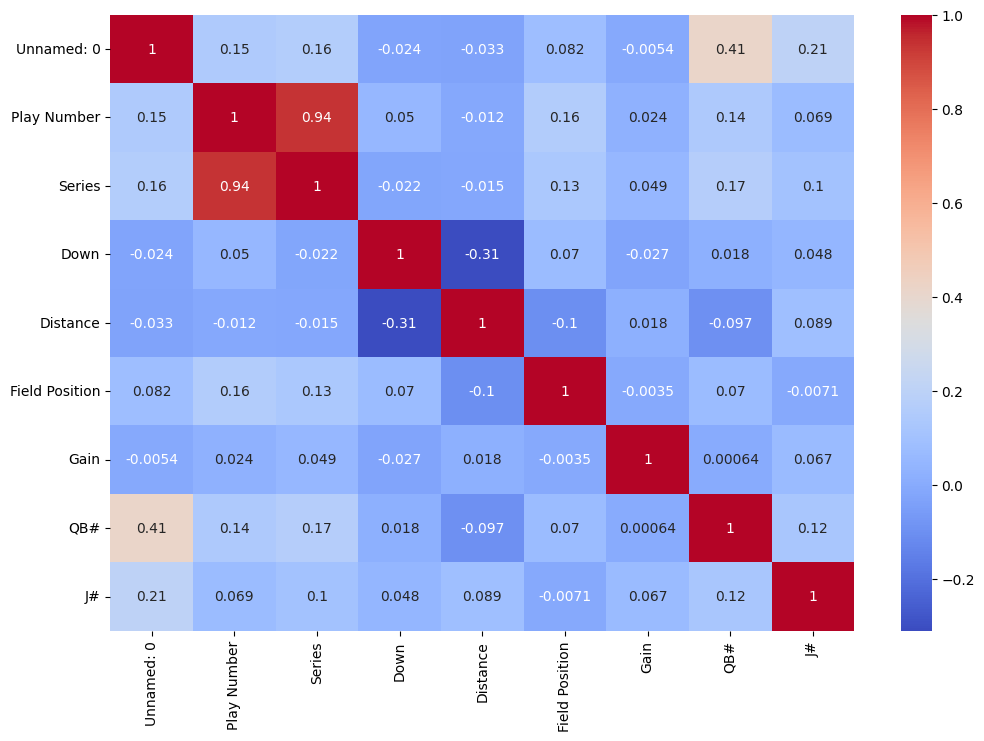

In [46]:
correlation_matrix = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [47]:
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                Unnamed: 0  Play Number    Series      Down  Distance  \
Unnamed: 0        1.000000     0.146794  0.161633 -0.024037 -0.033248   
Play Number       0.146794     1.000000  0.938074  0.049971 -0.012008   
Series            0.161633     0.938074  1.000000 -0.021604 -0.014958   
Down             -0.024037     0.049971 -0.021604  1.000000 -0.309778   
Distance         -0.033248    -0.012008 -0.014958 -0.309778  1.000000   
Field Position    0.081901     0.157471  0.130308  0.069890 -0.101985   
Gain             -0.005408     0.023882  0.048717 -0.027484  0.017803   
QB#               0.413741     0.144904  0.169943  0.018196 -0.097193   
J#                0.206438     0.069368  0.101673  0.047550  0.089233   

                Field Position      Gain       QB#        J#  
Unnamed: 0            0.081901 -0.005408  0.413741  0.206438  
Play Number           0.157471  0.023882  0.144904  0.069368  
Series                0.130308  0.048717  0.169943  0.101673

In [48]:
# Selecting relevant features for the LSTM model
selected_features = ['Play Number', 'Series', 'Down', 'Distance', 'Field Position', 'Gain',
                     'Formation', 'Motion', 'Play', 'Run Concept', 'The_Play',
                     'R/P', 'Pass Result']

In [49]:
# Adding lagged features for 'QB Comment'
num_lags = 5
for lag in range(1, num_lags + 1):
    data[f'QB_Comment_lag_{lag}'] = data['QB Comment'].shift(lag)

In [50]:
# Dropping rows with NaN values created due to lagging
data.dropna(inplace=True)

In [51]:
# Encoding categorical variables
categorical_columns = data[selected_features].select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

In [52]:
# Normalizing numerical features
numerical_columns = data[selected_features].select_dtypes(include=['float64', 'int64']).columns
scaler = MinMaxScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

In [53]:
# Defining the target variable (QB Comment) and encoding it
target_variable = 'QB Comment'
le_target = LabelEncoder()
data[target_variable] = le_target.fit_transform(data[target_variable])

In [54]:
# Split the dataset into main and hold-out sets
main_data, holdout_data = train_test_split(data, test_size=0.2, random_state=42)

In [55]:
# Further split the main dataset into training, validation, and test sets
split_index_1 = int(len(main_data) * 0.6)  # 60% for training
split_index_2 = int(len(main_data) * 0.8)  # Next 20% for validation, remaining for testing

In [56]:
train_data = main_data[:split_index_1]
validation_data = main_data[split_index_1:split_index_2]
test_data = main_data[split_index_2:]

In [57]:
# Extract features and target for each set
X_train, y_train = train_data[selected_features].values, train_data[target_variable].values
X_validation, y_validation = validation_data[selected_features].values, validation_data[target_variable].values
X_test, y_test = test_data[selected_features].values, test_data[target_variable].values
X_holdout, y_holdout = holdout_data[selected_features].values, holdout_data[target_variable].values

In [58]:
# Defining the window size for the LSTM model
window_size = 5  # Using 5 previous time steps to predict the next one

In [59]:
# Create time series generators
train_generator = TimeseriesGenerator(X_train, y_train, length=window_size, batch_size=1)
validation_generator = TimeseriesGenerator(X_validation, y_validation, length=window_size, batch_size=1)
test_generator = TimeseriesGenerator(X_test, y_test, length=window_size, batch_size=1)

In [60]:
# Building the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(window_size, X_train.shape[1])),
    Dense(units=len(np.unique(y_train)), activation='softmax')  # Adjust units based on the number of unique target classes
])

In [61]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_generator, epochs=10, validation_data=validation_generator)

# Model summary
model.summary()

Epoch 1/10
367/367 [==============================] - 4s 6ms/step - loss: 1.8952 - accuracy: 0.3787 - val_loss: 2.0266 - val_accuracy: 0.3613
Epoch 2/10
367/367 [==============================] - 2s 5ms/step - loss: 1.8171 - accuracy: 0.3978 - val_loss: 1.9150 - val_accuracy: 0.3613
Epoch 3/10
367/367 [==============================] - 2s 5ms/step - loss: 1.8030 - accuracy: 0.3978 - val_loss: 1.9468 - val_accuracy: 0.3613
Epoch 4/10
367/367 [==============================] - 2s 5ms/step - loss: 1.8034 - accuracy: 0.3978 - val_loss: 1.9115 - val_accuracy: 0.3613
Epoch 5/10
367/367 [==============================] - 2s 5ms/step - loss: 1.7886 - accuracy: 0.3978 - val_loss: 1.9056 - val_accuracy: 0.3613
Epoch 6/10
367/367 [==============================] - 3s 7ms/step - loss: 1.7773 - accuracy: 0.3978 - val_loss: 1.9655 - val_accuracy: 0.3613
Epoch 7/10
367/367 [==============================] - 2s 5ms/step - loss: 1.7786 - accuracy: 0.3978 - val_loss: 1.9210 - val_accuracy: 0.3613
Epoch 

In [62]:
# Evaluate the model on the training set
train_evaluation = model.evaluate(train_generator)
print(f'Training Set Evaluation: Loss = {train_evaluation[0]}, Accuracy = {train_evaluation[1]}')

367/367 [==============================] - 1s 3ms/step - loss: 1.7134 - accuracy: 0.3978
Training Set Evaluation: Loss = 1.713442087173462, Accuracy = 0.3978201746940613


In [63]:
# Evaluate the model on the test set
evaluation = model.evaluate(test_generator)
print(f'Test Set Evaluation: {evaluation}')

119/119 [==============================] - 0s 2ms/step - loss: 1.9139 - accuracy: 0.3866
Test Set Evaluation: [1.913894772529602, 0.38655462861061096]


In [64]:
# Evaluate the model on the validation set
validation_evaluation = model.evaluate(validation_generator)
print(f'Validation Set Evaluation: Loss = {validation_evaluation[0]}, Accuracy = {validation_evaluation[1]}')

119/119 [==============================] - 0s 2ms/step - loss: 1.9079 - accuracy: 0.3613
Validation Set Evaluation: Loss = 1.9079198837280273, Accuracy = 0.3613445460796356


In [65]:
# To evaluate on the holdout set, create a generator for it and evaluate as well
holdout_generator = TimeseriesGenerator(X_holdout, y_holdout, length=window_size, batch_size=1)
holdout_evaluation = model.evaluate(holdout_generator)
print(f'Holdout Set Evaluation: {holdout_evaluation}')

150/150 [==============================] - 0s 2ms/step - loss: 1.8258 - accuracy: 0.4133
Holdout Set Evaluation: [1.825768232345581, 0.41333332657814026]
